<a href="https://colab.research.google.com/github/bdip635/Histopathology-Classification/blob/main/RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import os
import math
from tqdm import tqdm

In [2]:
!pip install pkbar
import pkbar

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Setting the input parameters

In [4]:
device = 'cuda'

batch_size= 32
num_classes= 4
input_shape=(3,224,224)

layers= [3,4,6,3]

In [6]:
main = 'drive/My Drive/Course Project Image Processing - Histopathology/KMC Dataset'
work = 'drive/My Drive/Course Project Image Processing - Histopathology/db_dir'

train_dir = os.path.join(main,'Training')
test_dir = os.path.join(main,'Test')
val_dir = os.path.join(main,'Validation')

check_pt_file = os.path.join(work, 'resnet_cp.pth.tar')

In [8]:
train_data= datasets.ImageFolder(train_dir, transform= transforms.ToTensor())
test_data= datasets.ImageFolder(test_dir, transform= transforms.ToTensor())
val_data= datasets.ImageFolder(val_dir, transform= transforms.ToTensor())

In [9]:
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [10]:
class_dict=train_data.class_to_idx
print(class_dict)
class_labels = class_dict.values()
print(class_labels)

{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3}
dict_values([0, 1, 2, 3])


### Plotting the images with classes


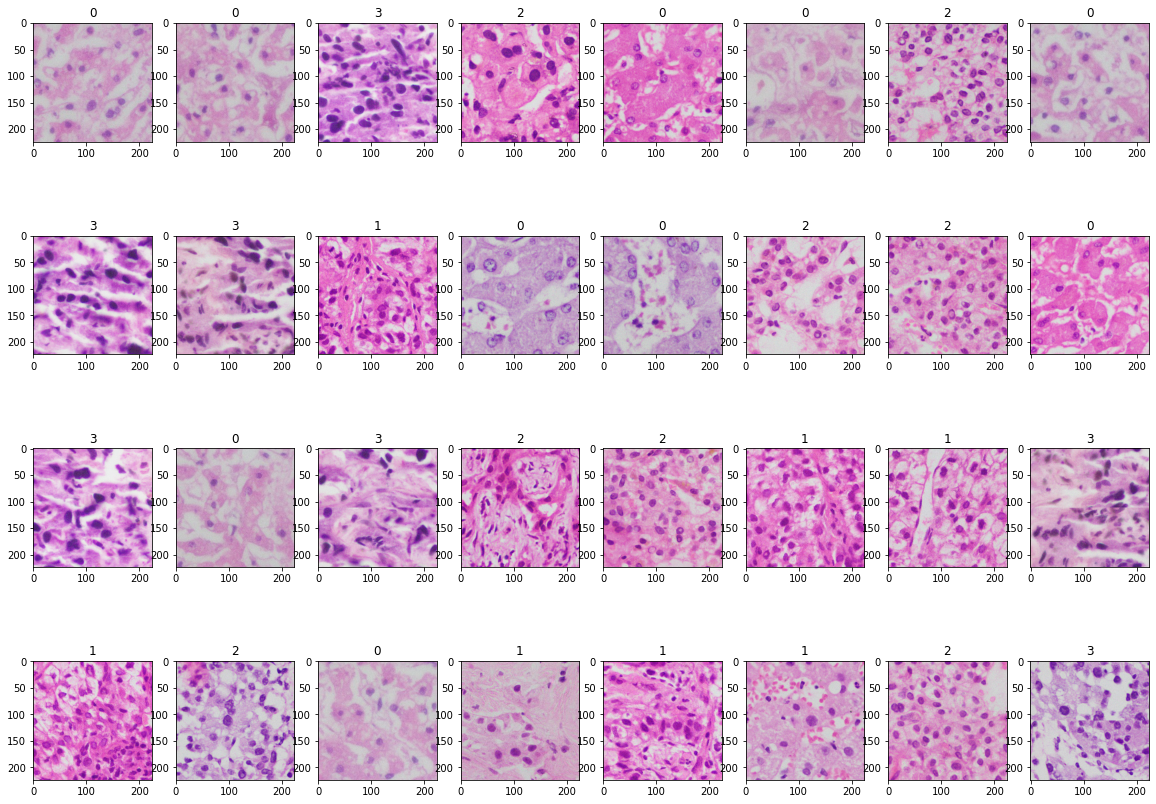

In [11]:
iterator= iter(train_loader)
it= next(iterator)
images, labels= it

plt.figure(figsize=(20,15))
for r in range(batch_size):
    plt.subplot(4,8,r+1)
    f= plt.imshow(images[r].permute(2,1,0))
    plt.title(labels[r].item())
plt.show()

## Model Definition

In [12]:
class Residual_Block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample= None, stride=1):
    super(Residual_Block,self).__init__()
    self.expn= 4
    self.conv1= nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1= nn.BatchNorm2d(num_features=out_channels)
    self.conv2= nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2= nn.BatchNorm2d(num_features=out_channels)
    self.conv3= nn.Conv2d(in_channels= out_channels, out_channels=out_channels*self.expn, kernel_size=1, stride=1, padding=0)
    self.bn3= nn.BatchNorm2d(num_features=out_channels*self.expn)
    self.relu= nn.ReLU()
    self.identity_downsample= identity_downsample

  def forward(self,x):

    identity=x
    x= nn.Sequential(self.conv1,
                     self.bn1,
                     self.conv2,
                     self.bn2,
                     self.conv3,
                     self.bn3)(x)
    if self.identity_downsample is not None:
      identity= self.identity_downsample(identity)
    
    x+= identity
    x=self.relu(x)
    
    return x

In [13]:
class ResNet(nn.Module):
  def __init__(self, Residual_Block, layers, image_channels, num_classes):
    super(ResNet,self).__init__()
    self.in_channels=64
    self.conv1= nn.Conv2d(in_channels=image_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
    self.bn1= nn.BatchNorm2d(num_features= 64)
    self.relu= nn.ReLU()
    self.maxpool= nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer_1= self._make_layer(Residual_Block, layers[0], out_channels=64, stride=1)
    self.layer_2= self._make_layer(Residual_Block, layers[1], out_channels=128, stride=2)
    self.layer_3= self._make_layer(Residual_Block, layers[2], out_channels=256, stride=2)
    self.layer_4= self._make_layer(Residual_Block, layers[3], out_channels=512, stride=2)

    self.avgpool= nn.AdaptiveAvgPool2d((1,1))
    self.fc= nn.Linear(512*4, num_classes)

  def forward(self,x):
    x= nn.Sequential(self.conv1,
                         self.bn1,
                         self.relu,
                         self.maxpool,
                         self.layer_1,
                         self.layer_2,
                         self.layer_3,
                         self.layer_4,
                         self.avgpool)(x)
    x= x.reshape(x.shape[0], -1)
    x= self.fc(x)
    return x


  def _make_layer(self,Residual_Block, num_res_blocks, out_channels, stride):
    identity_downsample= None
    layers=[]

    if stride!=1 or self.in_channels!=out_channels*4:
      identity_downsample= nn.Sequential(nn.Conv2d(in_channels=self.in_channels,
                                                   out_channels= out_channels*4,
                                                   kernel_size=1,
                                                   stride=stride),
                                         nn.BatchNorm2d(out_channels*4))
    layers.append(Residual_Block(self.in_channels, out_channels, identity_downsample, stride))
    self.in_channels= out_channels*4

    for i in range(num_res_blocks-1):
      layers.append(Residual_Block(self.in_channels, out_channels))
    return nn.Sequential(*layers)

  

In [14]:
def ResNet50(img_channels=3, num_classes=num_classes):
  return ResNet(Residual_Block, layers, img_channels, num_classes)

In [15]:
model= ResNet50(img_channels=input_shape[0], num_classes=num_classes).to(device)
summary(model, input_size= input_shape, batch_size=batch_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,472
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,160
       BatchNorm2d-6           [32, 64, 56, 56]             128
            Conv2d-7           [32, 64, 56, 56]          36,928
       BatchNorm2d-8           [32, 64, 56, 56]             128
            Conv2d-9          [32, 256, 56, 56]          16,640
      BatchNorm2d-10          [32, 256, 56, 56]             512
           Conv2d-11          [32, 256, 56, 56]          16,640
      BatchNorm2d-12          [32, 256, 56, 56]             512
             ReLU-13          [32, 256, 56, 56]               0
   Residual_Block-14          [32, 256,

#Training

In [17]:
learning_rate = 1e-3
num_epochs = 30

In [18]:
Loss= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
def check_accuracy(scores, targets):

  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct+= (predictions== targets).sum()
  num_samples= predictions.size(0)

  return num_correct/num_samples

In [20]:
def save_checkpoint(model, optimizer, file_name):

  checkpoint= {'state_dict': model.state_dict(),
             'optimizer_dict': optimizer.state_dict()}
  torch.save(checkpoint,file_name)

def load_checkpoint(model, optimizer, file_name):
  check_pt= torch.load(file_name, map_location=torch.device(device))
  model.load_state_dict(check_pt['state_dict'])
  optimizer.load_state_dict(check_pt['optimizer_dict'])

  return model, optimizer

In [22]:
train_per_epoch= len(train_loader)
val_per_epoch= len(val_loader)
min_loss= math.inf
min_loss

for epoch in range(num_epochs):
  train_losses=[]
### TRAINING
  kbar_train= pkbar.Kbar(target= train_per_epoch, epoch=epoch, num_epochs=num_epochs)

  train_loop= enumerate(train_loader)
  val_loop= enumerate(val_loader)
  for batch_idx, (data,targets) in train_loop:
    model.train()

    data= data.to(device=device)
    targets= targets.to(device=device)

    # FORWARD PROP
    scores= model(data)
    train_loss= Loss(scores, targets)
    train_losses.append(train_loss.item())

    # BACKWARD PROP
    optimizer.zero_grad()
    train_loss.backward()

    optimizer.step()

    train_acc= check_accuracy(scores,targets)
    kbar_train.update(batch_idx, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])
  kbar_train.update(train_per_epoch, values=None)
### VALIDATION
  kbar_val= pkbar.Kbar(target= val_per_epoch, epoch=epoch, num_epochs=num_epochs)
  val_losses=[]
  for batch_idx, (data, targets) in val_loop:
    model.eval()
    
    data= data.to(device=device)
    targets= targets.to(device=device)
    scores= model(data)
    val_loss= Loss(scores, targets)
    val_losses.append(val_loss.item())
    val_acc= check_accuracy(scores,targets)

    kbar_val.update(batch_idx, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])

  if np.mean(val_losses)<min_loss:
    min_loss= np.mean(val_losses)
    print('\nImproved validation loss: {:.4f}'.format(val_loss.item()))
    print('Saving the model to {}\n'.format(check_pt_file))
    save_checkpoint(model, optimizer, check_pt_file)
    
  kbar_val.update(val_per_epoch, values=None)

Epoch: 1/30
83/83 [==============================] - 895s 11s/step - loss: 0.8122 - accuracy: 0.6711
Epoch: 1/30
8/9 [=========================>....] - ETA: 11s - val_loss: 1.0073 - val_accuracy: 0.5260
Improved validation loss: 1.0569
Saving the model to drive/My Drive/Course Project Image Processing - Histopathology/db_dir/resnet_cp.pth.tar

9/9 [==============================] - 95s 11s/step - val_loss: 1.0073 - val_accuracy: 0.5260
Epoch: 2/30
83/83 [==============================] - 41s 493ms/step - loss: 0.4566 - accuracy: 0.7499
Epoch: 2/30
8/9 [=========================>....] - ETA: 0s - val_loss: 0.8091 - val_accuracy: 0.6914
Improved validation loss: 0.8834
Saving the model to drive/My Drive/Course Project Image Processing - Histopathology/db_dir/resnet_cp.pth.tar

9/9 [==============================] - 3s 368ms/step - val_loss: 0.8091 - val_accuracy: 0.6914
Epoch: 3/30
83/83 [==============================] - 40s 481ms/step - loss: 0.4365 - accuracy: 0.7883
Epoch: 3/30
9/9 [

#Testing

In [23]:
def CONFUSION_MATRIX(y_true, y_pred, class_labels, order=False):
  
  num_classes= len(class_labels)
  num_examples= len(y_true)

  if order is False:
    new_labels= np.arange(num_classes)
    
    for i in range(num_examples):
      y_true[i].item= np.where(class_labels==y_true[i])[0]
      y_pred[i].item= np.where(class_labels==y_pred[i])[0]

  mat= np.zeros((num_classes,num_classes), dtype=np.int)
  
  for i in range(num_examples):
    true= np.uint8(y_true[i].item())
    pred= np.uint8(y_pred[i].item())

    mat[true,pred]+=1

  return mat


def acc_precision_recall_f1(confusion_matrix):

  num_classes= confusion_matrix.shape[0]
  precision=      np.zeros((num_classes,1), np.float64)
  recall=         np.zeros((num_classes,1), np.float64)
  true_positives= np.zeros((num_classes,1), np.float64)
  true_negatives= np.zeros((num_classes,1), np.float64)
  accuracy=       np.zeros((num_classes,1), np.float64)
  f1=             np.zeros((num_classes,1), np.float64)

  for i in range(num_classes):
    
    true_positives[i]= confusion_matrix[i,i]
    precision[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[i])
    recall[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[:,i])
    f1[i]= 2*precision[i]*recall[i]/(precision[i]+recall[i])
  

  for i in range(num_classes):
    true_negatives[i]=0
    for j in range(num_classes):
      for k in range(num_classes):
        if (j!=i) and (k!=i):
          true_negatives[i]+=confusion_matrix[j,k]

  accuracy= (true_positives+true_negatives)/np.sum(confusion_matrix)
  return accuracy, precision, recall, f1


def Final_Metrics(loader, model, class_labels):

    model.eval()
    size= len(class_labels)
    c_mat= np.zeros((size,size), dtype= np.int)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores= model(x)
            _, preds = scores.max(1)

            c_mat+= CONFUSION_MATRIX(y, preds, class_labels, order= True)
    
    accuracy, precision, recall, f1= acc_precision_recall_f1(c_mat)

    return c_mat, accuracy, precision, recall, f1

In [24]:
resnet, _= load_checkpoint(model, optimizer, check_pt_file)
confusion_matrix, accuracy, precision, recall, f1= Final_Metrics(test_loader, resnet, class_labels)

In [25]:
print('CONFUSION MATRIX:\n',confusion_matrix,'\n')

print("PRECISION:",precision)
print("RECALL:",recall)
print("F1 SCORE:",f1)
print("ACCURACY:",accuracy)

print("PRECISION:",np.mean(precision))
print("RECALL:",np.mean(recall))
print("F1 SCORE:",np.mean(f1))
print("ACCURACY:",np.mean(accuracy))

CONFUSION MATRIX:
 [[70  0  0  0]
 [ 6 74  0  0]
 [ 0 32 48  0]
 [ 1  3  2 44]] 

PRECISION: [[1.   ]
 [0.925]
 [0.6  ]
 [0.88 ]]
RECALL: [[0.90909091]
 [0.67889908]
 [0.96      ]
 [1.        ]]
F1 SCORE: [[0.95238095]
 [0.78306878]
 [0.73846154]
 [0.93617021]]
ACCURACY: [[0.975     ]
 [0.85357143]
 [0.87857143]
 [0.97857143]]
PRECISION: 0.85125
RECALL: 0.8869974979149291
F1 SCORE: 0.8525203716693078
ACCURACY: 0.9214285714285715
